## Проект e-commerce: вариант 1   
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)
3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 
5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. (10 баллов)
6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. (35 баллов)
###  
#### Файлы:
***olist_customers_datase.csv*** — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
- customer_unique_id —  уникальный идентификатор пользователя
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

***olist_orders_dataset.csv*** —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

***olist_order_items_dataset.csv*** —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара  

Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5   

**Уникальные статусы заказов в таблице olist_orders_dataset:**
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
pip install squarify

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify

%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize':(13, 5)})

In [4]:
import requests
from urllib.parse import urlencode

In [5]:
users_public_key = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_public_key = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
items_public_key = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [6]:
def get_yandex_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [7]:
users = pd.read_csv(get_yandex_download_url(users_public_key))
users.head(3)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [8]:
orders = pd.read_csv(get_yandex_download_url(orders_public_key))
orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

In [9]:
items = pd.read_csv(get_yandex_download_url(items_public_key))
items.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

### Задание 1:   
Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [10]:
users.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [11]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [12]:
# смотрим количество пропущенных значений
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [13]:
# вглядываемся в строки с пропущенными значениями
orders[orders.isna().any(axis=1)]

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44     ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103    0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128    15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154    6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   
...                                 ...                               ...   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99313  e9e64a17afa9653aacf2616d94c005b8  b4cd0522e632e481f8eaf766a2646e86   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   
99348  a69ba794cc7deb415c3e15a0a3877e69  726f0894b5becdf952ea537d5266e543   
99415  5fabc81b6322c8443648e1b21a6fef21  32c9df889d41b0ee8309a5efb6855dcb   

      order_status order_purchase_timestamp    order_approved_at  \
6         invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48  2018-06-05 04:31:18   
103       invoiced      2018-08-03 17:44:42  2018-08-07 06:15:14   
128     processing      2017-09-03 14:22:03  2017-09-03 14:30:09   
154        shipped      2018-01-10 11:33:07  2018-01-11 02:32:30   
...            ...                      ...                  ...   
99283     canceled      2018-08-31 16:13:44                  NaN   
99313   processing      2018-01-05 23:07:24  2018-01-09 07:18:05   
99347     canceled      2018-09-06 18:45:47                  NaN   
99348  unavailable      2017-08-23 16:28:04  2017-08-28 15:44:47   
99415  unavailable      2017-10-10 10:50:03  2017-10-14 18:35:57   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaN                           NaN   
44             2018-06-05 14:32:00                           NaN   
103                            NaN                           NaN   
128                            NaN                           NaN   
154            2018-01-11 19:39:23                           NaN   
...                            ...                           ...   
99283                          NaN                           NaN   
99313                          NaN                           NaN   
99347                          NaN                           NaN   
99348                          NaN                           NaN   
99415                          NaN                           NaN   

      order_estimated_delivery_date  
6               2017-05-09 00:00:00  
44              2018-06-28 00:00:00  
103             2018-08-21 00:00:00  
128             2017-10-03 00:00:00  
154             2018-02-07 00:00:00  
...                             ...  
99283           2018-10-01 00:00:00  
99313           2018-02-06 00:00:00  
99347           2018-09-27 00:00:00  
99348           2017-09-15 00:00:00  
99415           2017-10-23 00:00:00  

[2980 rows x 8 columns]

In [14]:
# смотрим количество заказов c каждым из статусов
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [15]:
cols = ['order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [16]:
# Для изучения данных о заказах создаем фрейм с примерами записей по одному заказу 
# на каждый вариант статуса.
df = pd.DataFrame()
for status in orders['order_status'].unique():
    df = df.append(pd.DataFrame(orders[orders['order_status'] == status] \
                                .head(1).drop(['order_id', 'customer_id'], axis=1)))
df

order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
6         invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48  2018-06-05 04:31:18   
128     processing      2017-09-03 14:22:03  2017-09-03 14:30:09   
266    unavailable      2017-11-16 15:09:28  2017-11-16 15:26:57   
397       canceled      2018-08-04 14:29:27  2018-08-07 04:10:26   
7434       created      2017-12-05 01:07:52                  NaN   
44897     approved      2017-02-06 20:18:17  2017-02-06 20:30:19   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
6                              NaN                           NaN   
44             2018-06-05 14:32:00                           NaN   
128                            NaN                           NaN   
266                            NaN                           NaN   
397                            NaN                           NaN   
7434                           NaN                           NaN   
44897                          NaN                           NaN   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
6               2017-05-09 00:00:00  
44              2018-06-28 00:00:00  
128             2017-10-03 00:00:00  
266             2017-12-05 00:00:00  
397             2018-08-14 00:00:00  
7434            2018-01-11 00:00:00  
44897           2017-03-01 00:00:00

In [17]:
orders[orders['order_status'] == 'canceled'].head()

order_id                       customer_id  \
397   1b9ecfe83cdc259250e1a8aca174f0ad  6d6b50b66d79f80827b6d96751528d30   
613   714fb133a6730ab81fa1d3c1b2007291  e3fe72696c4713d64d3c10afe71e75ed   
1058  3a129877493c8189c59c60eb71d97c29  0913cdce793684e52bbfac69d87e91fd   
1130  00b1cb0320190ca0daa2c88b35206009  3532ba38a3fd242259a514ac2b6ae6b6   
1801  ed3efbd3a87bea76c2812c66a0b32219  191984a8ba4cbb2145acb4fe35b69664   

     order_status order_purchase_timestamp    order_approved_at  \
397      canceled      2018-08-04 14:29:27  2018-08-07 04:10:26   
613      canceled      2018-01-26 21:34:08  2018-01-26 21:58:39   
1058     canceled      2018-01-25 13:34:24  2018-01-25 13:50:20   
1130     canceled      2018-08-28 15:26:39                  NaN   
1801     canceled      2018-09-20 13:54:16                  NaN   

     order_delivered_carrier_date order_delivered_customer_date  \
397                           NaN                           NaN   
613           2018-01-29 22:33:25                           NaN   
1058          2018-01-26 21:42:18                           NaN   
1130                          NaN                           NaN   
1801                          NaN                           NaN   

     order_estimated_delivery_date  
397            2018-08-14 00:00:00  
613            2018-02-22 00:00:00  
1058           2018-02-23 00:00:00  
1130           2018-09-12 00:00:00  
1801           2018-10-17 00:00:00

In [18]:
orders[orders['order_status'] == 'unavailable'].head()

order_id                       customer_id  \
266   8e24261a7e58791d10cb1bf9da94df5c  64a254d30eed42cd0e6c36dddb88adf0   
586   c272bcd21c287498b4883c7512019702  9582c5bbecc65eb568e2c1d839b5cba1   
687   37553832a3a89c9b2db59701c357ca67  7607cd563696c27ede287e515812d528   
737   d57e15fb07fd180f06ab3926b39edcd2  470b93b3f1cde85550fc74cd3a476c78   
1160  2f634e2cebf8c0283e7ef0989f77d217  7353b0fb8e8d9675e3a704c60ca44ebe   

     order_status order_purchase_timestamp    order_approved_at  \
266   unavailable      2017-11-16 15:09:28  2017-11-16 15:26:57   
586   unavailable      2018-01-31 11:31:37  2018-01-31 14:23:50   
687   unavailable      2017-08-14 17:38:02  2017-08-17 00:15:18   
737   unavailable      2018-01-08 19:39:03  2018-01-09 07:26:08   
1160  unavailable      2017-09-27 20:55:33  2017-09-28 01:32:50   

     order_delivered_carrier_date order_delivered_customer_date  \
266                           NaN                           NaN   
586                           NaN                           NaN   
687                           NaN                           NaN   
737                           NaN                           NaN   
1160                          NaN                           NaN   

     order_estimated_delivery_date  
266            2017-12-05 00:00:00  
586            2018-02-16 00:00:00  
687            2017-09-05 00:00:00  
737            2018-02-06 00:00:00  
1160           2017-10-27 00:00:00

### Результаты эксплораторного анализа таблицы orders

После совершения оплаты и присвоения времени полю 'order_approved_at' и статуса 'approved',
может пройзойти события вызывающие статусы 'canceled' и 'unavailable' и заказ не будет доставлен.  
'canceled' может быть связан как с отказом клиента от заказа, так и с факторами не зависящими от клиента.  
'unavailable' - с какими-то ошибками на складе и с недоступностью товаров.
####  
Расширенное описание статусов, на основе анализа данных в таблице orders:
- created —  отражает факт размещения заказа
- approved — отражает факт проведения оплаты
- invoiced — факт изготовления инвойса (в описании задания ошибка - этому статусу сопоставляется выставление счета. Во-первых, инвойс выдается только после оплаты и не может быть счетом. А во-вторых в таблице заказов у заказов со статусом 'invoiced' (если это и правда счет) не может быть времени произведения оплаты, а она есть. После этого может случиться 'canceled'  
    - Wiki: Инвойс (англ. invoice) — в международной коммерческой практике документ, предоставляемый продавцом покупателю и содержащий перечень товаров и услуг, их количество и цену, по которой они поставлены покупателю, формальные особенности товара, обработку и условия поставки, налоговые сборы и сведения об отправителе и получателе.
- processing —  в процессе сборки заказа, после этого может случиться 'canceled'
- shipped —  отгружен со склада, после этого может случиться 'canceled'
- delivered —  доставлен пользователю, всё хорошо
- unavailable —  товар недоступен, статус появляется после произведения оплаты клиентом (неправильные данные о наличии товара на складе, например)
- canceled —  отменён. По разным причинам:
    - order_approved_at == NaN - оплата не произведена. Заказ отменен до факта оплаты, скорее всего по инициативе клиента
    - order_delivered_carrier_date == NaN - время передачи заказа в логистическую службу не прописано. Заказ отменен на этапе обработки
    - order_delivered_customer_date == NaN - заказ не доставлен (утерян, испорчен)

###  
Факт произведения оплаты клиентом отражается записью о времени 'order_approved_at' подтверждения оплаты  и статусом 'approved' в таблице заказов.
###  
Требуется посчитать количество пользователей, которые произвели покупку только один раз.
Какие статусы заказов удовлетворяют такому запросу?
- Максимально консервативно: нам нужны заказы со статусами delivered, потому как, даже на этапе доставки у заказа может случиться статус 'canceled'. Так можно фильтровать, если целью нашего анализа является исследование выполнения заказов, а не лояльность клиентов.
- Максимально либерально: нам нужны заказы со статусами кроме created, canceled, unavailable. То есть с момента оплаты заказа. Так можно фильтровать, если целью нашего анализа является лояльность клиентов, а не исследования выполения заказов.

In [19]:
# создаем фрейм orders_active с заказами, у которых статус не 'created', не 'unavailable' и не 'canceled'
orders_active = orders[~orders['order_status'].isin(['created', 'canceled', 'unavailable'])]
orders_active.order_id.count()
# Всего было оплачено заказов:

98202

In [20]:
orders_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
dtype: int64

In [21]:
users.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [22]:
# создаем фрейм из таблицы users, c клиентами у которых customer_id пересекается с customer_id 
# в таблице orders_active. Фактически в users_active лежит фрейм со всеми клиентами, которые
# совершили хотя бы одну оплату заказа
users_active = orders_active.merge(users, on='customer_id', how='left')

In [23]:
users_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
customer_unique_id               94986
customer_zip_code_prefix         14964
customer_city                     4109
customer_state                      27
dtype: int64

In [24]:
# вычисляем количество уникальных пользователей во фрейме users_active, которые произвели 
# хотя бы одну покупку
num_uniq_active_users = users_active.customer_unique_id.nunique()
num_uniq_active_users

94986

In [25]:
# cмотрим распределение клиентов по количеству совершенных покупок
users_by_purchases = users_active.groupby('customer_unique_id') \
                                 .agg({'customer_id': 'count'}) \
                                 .rename(columns={'customer_id': 'purchases'})
users_by_purchases

purchases
customer_unique_id                         
0000366f3b9a7992bf8c76cfdf3221e2          1
0000b849f77a49e4a4ce2b2a4ca5be3f          1
0000f46a3911fa3c0805444483337064          1
0000f6ccb0745a6a4b88665a16c9f078          1
0004aac84e0df4da2b147fca70cf8255          1
...                                     ...
fffcf5a5ff07b0908bd4e2dbc735a684          1
fffea47cd6d3cc0a88bd621562a9d061          1
ffff371b4d645b6ecea244b27531430a          1
ffff5962728ec6157033ef9805bacc48          1
ffffd2657e2aad2907e67c3e9daecbeb          1

[94986 rows x 1 columns]

### Распределение клиентов по количеству совершенных покупок (log)

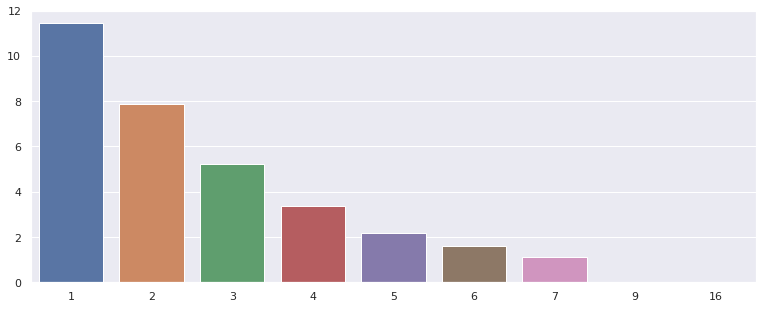

In [26]:
sns.barplot(y = np.log(users_by_purchases.purchases.value_counts().values),
            x = users_by_purchases.purchases.value_counts().index)

In [27]:
# вычисляем сколько клиентов совершили покупку (оплату) только один раз
num_users_one_purchase = (users_active.groupby('customer_unique_id') \
                          .agg({'customer_id': 'count'}) == 1).sum()

print(f'{num_users_one_purchase[0]} пользователей совершили покупку (хотя бы произвели оплату) только один раз')

92099 пользователей совершили покупку (хотя бы произвели оплату) только один раз


In [28]:
# либо, можно просто взять нулевое значение из value_counts()
users_by_purchases.purchases.value_counts().values[0]

92099

Ответ по 1 вопросу: 92099 пользователей, совершили покупку только один раз.  
Обоснование ответа есть выше.
####  
На случай, если нужна консервативная оценка, ниже есть вычисление с условием, что факт совершения покупки, считается совершённым только после доставки заказа клиенту:

In [29]:
orders_delivered = orders[orders['order_status'] == 'delivered']
orders_delivered.order_id.count() 
# Всего доставлено было заказов:

96478

In [30]:
# создаем фрейм из таблицы users, c клиентами у которых customer_id пересекается с customer_id 
# в таблице orders_delivered. Фактически в users_received лежит фрейм со всеми клиентами, которые
# получили хотя бы один заказ
users_received = users[users.customer_id.isin(orders_delivered.customer_id)]

# вычисляем количество уникальных пользователей во фрейме users_received, которые получили 
# хотя бы один заказ
num_uniq_received_users = users_received.customer_unique_id.nunique()
num_uniq_received_users

93358

In [31]:
# cмотрим распределение клиентов по количеству полученных заказов
users_by_received_orders = users_received.groupby('customer_unique_id') \
                                 .agg({'customer_id': 'count'}) \
                                 .rename(columns={'customer_id': 'delivered'})
users_by_received_orders.value_counts()

delivered
1            90557
2             2573
3              181
4               28
5                9
6                5
7                3
15               1
9                1
dtype: int64

In [32]:
print(f'{users_by_received_orders.value_counts().values[0]} \
пользователей совершили покупку (получили заказ) только один раз')

90557 пользователей совершили покупку (получили заказ) только один раз


### Задание 2:  
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [33]:
ls_dt = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
         'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[ls_dt] = orders[ls_dt].apply(pd.to_datetime)

In [34]:
orders[orders.order_status == 'canceled'].head()

order_id                       customer_id  \
397   1b9ecfe83cdc259250e1a8aca174f0ad  6d6b50b66d79f80827b6d96751528d30   
613   714fb133a6730ab81fa1d3c1b2007291  e3fe72696c4713d64d3c10afe71e75ed   
1058  3a129877493c8189c59c60eb71d97c29  0913cdce793684e52bbfac69d87e91fd   
1130  00b1cb0320190ca0daa2c88b35206009  3532ba38a3fd242259a514ac2b6ae6b6   
1801  ed3efbd3a87bea76c2812c66a0b32219  191984a8ba4cbb2145acb4fe35b69664   

     order_status order_purchase_timestamp   order_approved_at  \
397      canceled      2018-08-04 14:29:27 2018-08-07 04:10:26   
613      canceled      2018-01-26 21:34:08 2018-01-26 21:58:39   
1058     canceled      2018-01-25 13:34:24 2018-01-25 13:50:20   
1130     canceled      2018-08-28 15:26:39                 NaT   
1801     canceled      2018-09-20 13:54:16                 NaT   

     order_delivered_carrier_date order_delivered_customer_date  \
397                           NaT                           NaT   
613           2018-01-29 22:33:25                           NaT   
1058          2018-01-26 21:42:18                           NaT   
1130                          NaT                           NaT   
1801                          NaT                           NaT   

     order_estimated_delivery_date  
397                     2018-08-14  
613                     2018-02-22  
1058                    2018-02-23  
1130                    2018-09-12  
1801                    2018-10-17

In [35]:
orders_time_idx = orders.set_index('order_purchase_timestamp')
orders_time_idx.head()

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d   
2017-11-18 19:28:06       949d5b44dbf5de918fe9c16f97b45f8a   
2018-02-13 21:18:39       ad21c59c0840e6cb83a9ceb5573f8159   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-08 08:38:49       41ce2a54c0b03bf3443c3d931a367089    delivered   
2017-11-18 19:28:06       f88197465ea7920adcdbec7375364d82    delivered   
2018-02-13 21:18:39       8ab97904e6daea8866dbdbc4fb7aad2c    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-08 08:38:49      2018-08-08 08:55:23          2018-08-08 13:50:00   
2017-11-18 19:28:06      2017-11-18 19:45:59          2017-11-22 13:39:59   
2018-02-13 21:18:39      2018-02-13 22:20:29          2018-02-14 19:46:34   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2018-07-24 20:41:37                2018-08-07 15:27:45   
2018-08-08 08:38:49                2018-08-17 18:06:29   
2017-11-18 19:28:06                2017-12-02 00:28:42   
2018-02-13 21:18:39                2018-02-16 18:17:02   

                         order_estimated_delivery_date  
order_purchase_timestamp                                
2017-10-02 10:56:33                         2017-10-18  
2018-07-24 20:41:37                         2018-08-13  
2018-08-08 08:38:49                         2018-09-04  
2017-11-18 19:28:06                         2017-12-15  
2018-02-13 21:18:39                         2018-02-26

In [36]:
df = orders_time_idx \
    .query("order_status == 'canceled' | order_status == 'unavailable'") \
    .groupby('order_status', as_index=True) \
    .resample(rule='M') \
    .order_id \
    .count() \
    .to_frame().reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders'})

df.month = df.month.dt.strftime("%Y %b")
df.head(3)

order_status     month  orders
0     canceled  2016 Sep       2
1     canceled  2016 Oct      24
2     canceled  2016 Nov       0

### Строим график, сколько заказов в месяц не доставляется по разным причинам (canceled либо unavailable)

[]

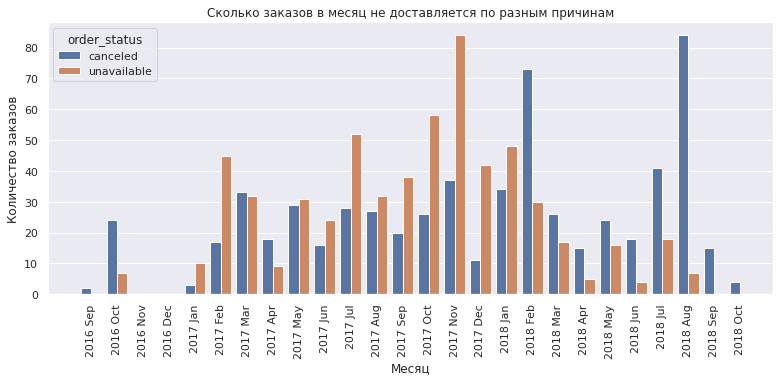

In [37]:
ax = sns.barplot(data=df, x='month', y='orders', hue='order_status')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Месяц', ylabel='Количество заказов',
       title='Сколько заказов в месяц не доставляется по разным причинам')
ax.plot()

Заметны повышения отмен со статусом 'unavailable': 2017-Nov  
и повышения отмен со статусом 'canceled': 2018-Feb и 2018-Aug  
Заметное цикличное нарастание отмен с каждым статусом. Цикл ~2-4 месяца

#### Ответ 1:
по разным причинам не доставляется в среднем столько заказов в месяц: 

In [38]:
df.groupby('order_status', as_index=False).agg({'orders': 'mean'})

order_status     orders
0     canceled  24.038462
1  unavailable  26.478261

#### Deeper... 
Детализация по причинам

- canceled —  отменён. По разным причинам:
    - order_approved_at == NaN - оплата не произведена. Заказ отменен до факта оплаты, скорее всего по инициативе клиента
    - order_delivered_carrier_date == NaN - время передачи заказа в логистическую службу не прописано. Заказ отменен на этапе обработки
    - order_delivered_customer_date == NaN - заказ не доставлен (утерян, испорчен)

In [39]:
orders_not_delivered = orders_time_idx[orders_time_idx.order_delivered_customer_date.isna()]
orders_not_delivered.order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [40]:
orders['deep_status'] = orders['order_status']

# заказы отмененные во время доставки
orders.loc[(orders['order_status'] == 'canceled') & 
           (orders['order_delivered_customer_date'].isna()), 
           'deep_status'] = 'canceled_by_carrier'
# заказы отмененные во время подготовки заказа к отправке
orders.loc[(orders['order_status'] == 'canceled') & 
           (orders['order_delivered_carrier_date'].isna()), 
           'deep_status'] = 'canceled_by_warehouse'
# заказы отмененные до совершения оплаты, по логике - по инициативе клиента
orders.loc[(orders['order_status'] == 'canceled') & 
           (orders['order_approved_at'].isna()), 
           'deep_status'] = 'canceled_by_customer'
# заказы отмененные после доставки товара, по логике - по инициативе клиента
orders.loc[(orders['deep_status'] == 'canceled'),    
           'deep_status'] = 'canceled_after_delivery'

orders.deep_status.value_counts()

delivered                  96478
shipped                     1107
unavailable                  609
canceled_by_warehouse        409
invoiced                     314
processing                   301
canceled_by_customer         141
canceled_by_carrier           69
canceled_after_delivery        6
created                        5
approved                       2
Name: deep_status, dtype: int64

In [41]:
orders_time_idx = orders.set_index('order_purchase_timestamp')

In [42]:
orders_time_idx.head(3)

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-08 08:38:49       41ce2a54c0b03bf3443c3d931a367089    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-08 08:38:49      2018-08-08 08:55:23          2018-08-08 13:50:00   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2018-07-24 20:41:37                2018-08-07 15:27:45   
2018-08-08 08:38:49                2018-08-17 18:06:29   

                         order_estimated_delivery_date deep_status  
order_purchase_timestamp                                            
2017-10-02 10:56:33                         2017-10-18   delivered  
2018-07-24 20:41:37                         2018-08-13   delivered  
2018-08-08 08:38:49                         2018-09-04   delivered

In [43]:
orders_by_month = orders_time_idx \
    .resample(rule='M') \
    .order_id \
    .count() \
    .to_frame() \
    .reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders'})

orders_by_month.month = orders_by_month.month.dt.strftime("%Y %b")
orders_by_month.head(3)

month  orders
0  2016 Sep       4
1  2016 Oct     324
2  2016 Nov       0

### Выводим количество заказов в каждом месяце

[]

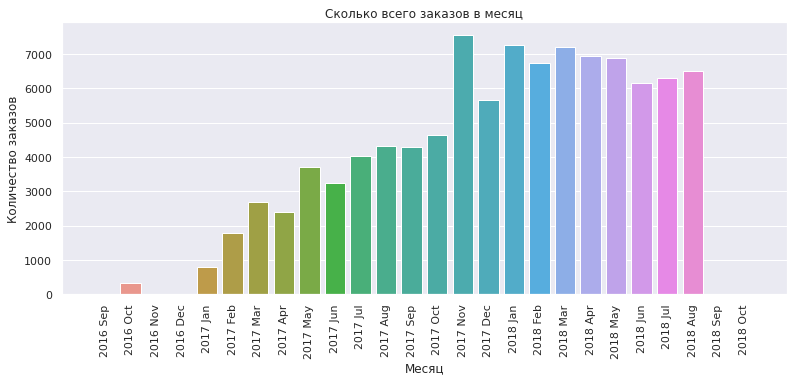

In [44]:
ax = sns.barplot(data=orders_by_month, x='month', y='orders')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Месяц', ylabel='Количество заказов',
       title='Сколько всего заказов в месяц')
ax.plot()

In [45]:
orders_time_idx.head(3)

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-08 08:38:49       41ce2a54c0b03bf3443c3d931a367089    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-08 08:38:49      2018-08-08 08:55:23          2018-08-08 13:50:00   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2018-07-24 20:41:37                2018-08-07 15:27:45   
2018-08-08 08:38:49                2018-08-17 18:06:29   

                         order_estimated_delivery_date deep_status  
order_purchase_timestamp                                            
2017-10-02 10:56:33                         2017-10-18   delivered  
2018-07-24 20:41:37                         2018-08-13   delivered  
2018-08-08 08:38:49                         2018-09-04   delivered

In [46]:
df = orders_time_idx \
    .query("order_status == 'canceled' | order_status == 'unavailable'") \
    .groupby(['deep_status', 'order_status']) \
    .resample(rule='M') \
    .order_id \
    .count() \
    .to_frame().reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders'})

df.month = df.month.dt.strftime("%Y %b")
df.head(3)

deep_status order_status     month  orders
0  canceled_after_delivery     canceled  2016 Oct       5
1  canceled_after_delivery     canceled  2016 Nov       0
2  canceled_after_delivery     canceled  2016 Dec       0

### Строим график, сколько заказов в месяц не доставляется по разным причинам

[]

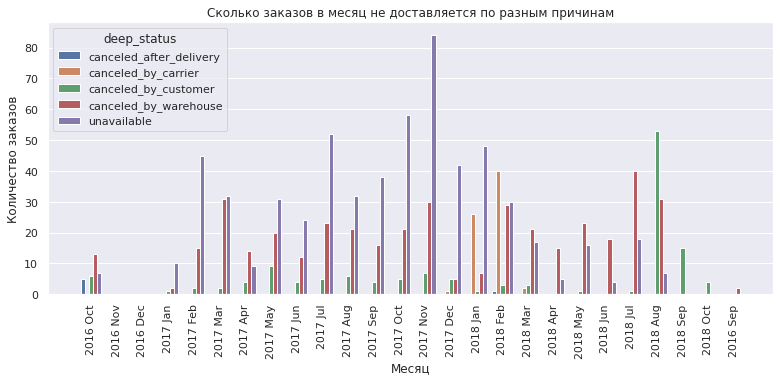

In [47]:
ax = sns.barplot(data=df, x='month', y='orders', hue='deep_status')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Месяц', ylabel='Количество заказов',
       title='Сколько заказов в месяц не доставляется по разным причинам')
ax.plot()

### ... и в другом виде

In [48]:
fig = px.bar(df, x='month', y='orders', color='deep_status',
             barmode='relative', title="Сколько заказов в месяц не доставляется по разным причинам")
fig.show()

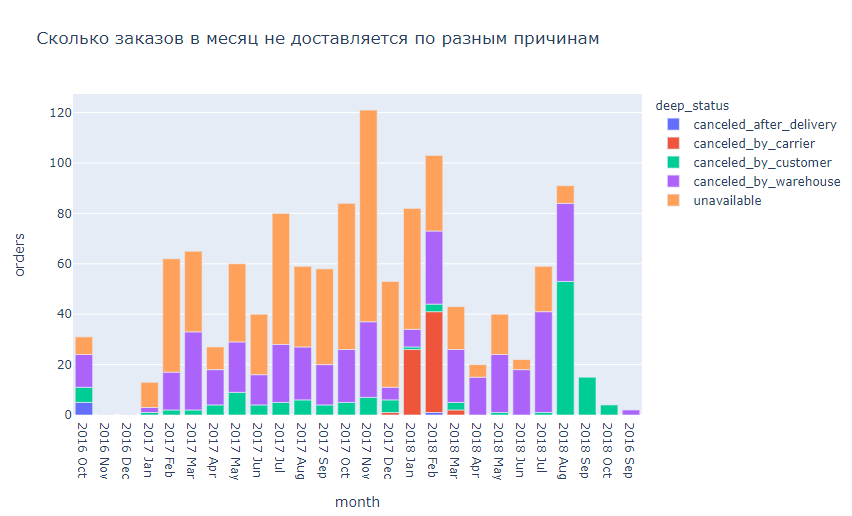

###  Выводы:
- отмены со стороны склада имеют случайный харатер и держатся приблизительно на одном уровне
- отмены со стороны клиента имеют всплеск в 2018-Aug и затем, затухают
- отмены со стороны перевозчика значительно возрастают в 2018-Jan и 2018-Feb
- отмен после свершения доставки почти нет
- unavailable возрастают 2017-Nov

### Ответ 2:
по разным причинам не доставляется в среднем столько заказов в месяц:

In [49]:
df.groupby('deep_status', as_index=False) \
        .agg({'orders': 'mean'})

deep_status     orders
0  canceled_after_delivery   0.352941
1      canceled_by_carrier  17.250000
2     canceled_by_customer   5.640000
3    canceled_by_warehouse  17.041667
4              unavailable  26.478261

### Задание 3:   
По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [50]:
orders_items = pd.merge(orders, items, how="left", on="order_id")
orders_items.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date deep_status  order_item_id  \
0                    2017-10-18   delivered            1.0   
1                    2018-08-13   delivered            1.0   
2                    2018-09-04   delivered            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

   shipping_limit_date   price  freight_value  
0  2017-10-06 11:07:15   29.99           8.72  
1  2018-07-30 03:24:27  118.70          22.76  
2  2018-08-13 08:55:23  159.90          19.22

In [51]:
orders_items['weekday'] = orders_items.order_purchase_timestamp.dt.day_name()
orders_items.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date deep_status  order_item_id  \
0                    2017-10-18   delivered            1.0   
1                    2018-08-13   delivered            1.0   
2                    2018-09-04   delivered            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

   shipping_limit_date   price  freight_value    weekday  
0  2017-10-06 11:07:15   29.99           8.72     Monday  
1  2018-07-30 03:24:27  118.70          22.76    Tuesday  
2  2018-08-13 08:55:23  159.90          19.22  Wednesday

In [52]:
# 1-й вариант решения, через моду
orders_items.groupby('product_id')['weekday'] \
            .agg(lambda x: pd.Series.mode(x).iloc[0]) \
            .to_frame().reset_index()

product_id    weekday
0      00066f42aeeb9f3007548bb9d3f33c38     Sunday
1      00088930e925c41fd95ebfe695fd2655    Tuesday
2      0009406fd7479715e4bef61dd91f2462   Thursday
3      000b8f95fcb9e0096488278317764d19     Friday
4      000d9be29b5207b54e86aa1b1ac54872    Tuesday
...                                 ...        ...
32946  fff6177642830a9a94a0f2cba5e476d1   Saturday
32947  fff81cc3158d2725c0655ab9ba0f712c     Monday
32948  fff9553ac224cec9d15d49f5a263411f     Friday
32949  fffdb2d0ec8d6a61f0a0a0db3f25b441    Tuesday
32950  fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday

[32951 rows x 2 columns]

In [53]:
# 2-й вариант решения, через pivot
orders_items.groupby(['product_id', 'weekday'], as_index=False)\
        .agg({'order_id': 'count'}) \
        .pivot(index='product_id', columns='weekday', values='order_id') \
        .idxmax(axis=1) \
        .to_frame().reset_index()

product_id          0
0      00066f42aeeb9f3007548bb9d3f33c38     Sunday
1      00088930e925c41fd95ebfe695fd2655    Tuesday
2      0009406fd7479715e4bef61dd91f2462   Thursday
3      000b8f95fcb9e0096488278317764d19     Friday
4      000d9be29b5207b54e86aa1b1ac54872    Tuesday
...                                 ...        ...
32946  fff6177642830a9a94a0f2cba5e476d1   Saturday
32947  fff81cc3158d2725c0655ab9ba0f712c     Monday
32948  fff9553ac224cec9d15d49f5a263411f     Friday
32949  fffdb2d0ec8d6a61f0a0a0db3f25b441    Tuesday
32950  fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday

[32951 rows x 2 columns]

### Задание 4:   
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [54]:
orders.head(1)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date deep_status  
0                    2017-10-18   delivered

In [55]:
users.head(1)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   

   customer_zip_code_prefix customer_city customer_state  
0                     14409        franca             SP

In [56]:
orders_users = pd.merge(orders, users, how="left", on="customer_id")

In [57]:
orders_users.set_index('order_purchase_timestamp', inplace=True)

In [58]:
orders_users.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
deep_status                         11
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
dtype: int64

In [59]:
orders_users.head(3)

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-08 08:38:49       41ce2a54c0b03bf3443c3d931a367089    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-08 08:38:49      2018-08-08 08:55:23          2018-08-08 13:50:00   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2018-07-24 20:41:37                2018-08-07 15:27:45   
2018-08-08 08:38:49                2018-08-17 18:06:29   

                         order_estimated_delivery_date deep_status  \
order_purchase_timestamp                                             
2017-10-02 10:56:33                         2017-10-18   delivered   
2018-07-24 20:41:37                         2018-08-13   delivered   
2018-08-08 08:38:49                         2018-09-04   delivered   

                                        customer_unique_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       7c396fd4830fd04220f754e42b4e5bff   
2018-07-24 20:41:37       af07308b275d755c9edb36a90c618231   
2018-08-08 08:38:49       3a653a41f6f9fc3d2a113cf8398680e8   

                          customer_zip_code_prefix customer_city  \
order_purchase_timestamp                                           
2017-10-02 10:56:33                           3149     sao paulo   
2018-07-24 20:41:37                          47813     barreiras   
2018-08-08 08:38:49                          75265    vianopolis   

                         customer_state  
order_purchase_timestamp                 
2017-10-02 10:56:33                  SP  
2018-07-24 20:41:37                  BA  
2018-08-08 08:38:49                  GO

###  График количества заказов каждого пользователя за весь период

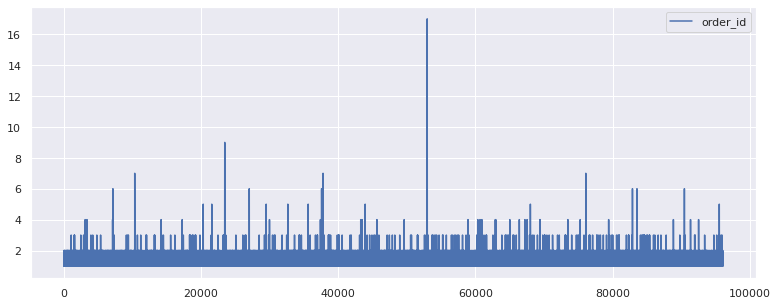

In [60]:
# Количество заказов у каждого пользователя
orders_users \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.count() \
    .plot()

Большинство покупает лишь единожды

In [61]:
# уменьшаем количество данных для ускорения ресемплирования
orders_users_3cols = orders_users[['customer_unique_id', 'customer_id', 'order_id']].sort_index()
orders_users_3cols.head(3)

customer_unique_id  \
order_purchase_timestamp                                     
2016-09-04 21:15:19       b7d76e111c89f7ebf14761390f0f7d17   
2016-09-05 00:15:34       4854e9b3feff728c13ee5fc7d1547e92   
2016-09-13 15:24:19       009b0127b727ab0ba422f6d9604487c7   

                                               customer_id  \
order_purchase_timestamp                                     
2016-09-04 21:15:19       08c5351a6aca1c1589a38f244edeee9d   
2016-09-05 00:15:34       683c54fc24d40ee9f8a6fc179fd9856c   
2016-09-13 15:24:19       622e13439d6b5a0b486c435618b2679e   

                                                  order_id  
order_purchase_timestamp                                    
2016-09-04 21:15:19       2e7a8482f6fb09756ca50c10d7bfc047  
2016-09-05 00:15:34       e5fa5a7210941f7d56d0208e4e071d35  
2016-09-13 15:24:19       809a282bbd5dbcabb6f2f724fca862ec

In [62]:
%%time
customer_orders_per_month = orders_users_3cols.head(1000) \
    .groupby('customer_unique_id', as_index=True) \
    .resample(rule='M') \
    .order_id.count() \
    .reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders_per_month'})
customer_orders_per_month.head(3)

CPU times: user 2.31 s, sys: 23.2 ms, total: 2.34 s
Wall time: 2.32 s


customer_unique_id      month  orders_per_month
0  00115fc7123b5310cf6d3a3aa932699e 2017-01-31                 1
1  0032c76b20340da25249092a268ce66c 2016-10-31                 1
2  008f3d5f45a11059239a5c452cd00006 2017-01-31                 1

Этот способ решения (через resample() оказался крайне медленным, если убрать .head(1000), то после 15 минут код всё еще продолжает выполняться.

#### Ход решения 2:

In [63]:
customer_orders_per_month2 = orders_users_3cols.reset_index()
# добавляем колонку с датой в формате 2016-Sep
customer_orders_per_month2.insert(loc=1, column='year_month', 
                value=customer_orders_per_month2.order_purchase_timestamp.dt.strftime('%Y-%b'))
customer_orders_per_month2.head(3)

order_purchase_timestamp year_month                customer_unique_id  \
0      2016-09-04 21:15:19   2016-Sep  b7d76e111c89f7ebf14761390f0f7d17   
1      2016-09-05 00:15:34   2016-Sep  4854e9b3feff728c13ee5fc7d1547e92   
2      2016-09-13 15:24:19   2016-Sep  009b0127b727ab0ba422f6d9604487c7   

                        customer_id                          order_id  
0  08c5351a6aca1c1589a38f244edeee9d  2e7a8482f6fb09756ca50c10d7bfc047  
1  683c54fc24d40ee9f8a6fc179fd9856c  e5fa5a7210941f7d56d0208e4e071d35  
2  622e13439d6b5a0b486c435618b2679e  809a282bbd5dbcabb6f2f724fca862ec

In [64]:
# считаем количество заказов в группировке 'клиент' + 'месяц'
customer_orders_per_month_w = customer_orders_per_month2 \
    .groupby(['customer_unique_id', 'year_month'], as_index=True) \
    .agg({'order_id': 'count'}) \
    .reset_index() \
    .rename(columns={'order_id': 'orders_per_month'})
customer_orders_per_month_w.orders_per_month.value_counts()

1    96720
2     1267
3       51
4        7
6        1
Name: orders_per_month, dtype: int64

In [65]:
# добавляем колонку с datetime64 для дальнейших вычислений дней в месяце
customer_orders_per_month_w['month_dt'] = pd.to_datetime(customer_orders_per_month_w.year_month)
customer_orders_per_month_w.head(3)

customer_unique_id year_month  orders_per_month   month_dt
0  0000366f3b9a7992bf8c76cfdf3221e2   2018-May                 1 2018-05-01
1  0000b849f77a49e4a4ce2b2a4ca5be3f   2018-May                 1 2018-05-01
2  0000f46a3911fa3c0805444483337064   2017-Mar                 1 2017-03-01

In [66]:
# считаем искомую метрику в группировке 'клиент' + 'месяц'.
customer_orders_per_month_w['orders_per_week'] = customer_orders_per_month_w.orders_per_month \
           / customer_orders_per_month_w.month_dt.dt.days_in_month.div(7)
customer_orders_per_month_w.head(3)

customer_unique_id year_month  orders_per_month   month_dt  \
0  0000366f3b9a7992bf8c76cfdf3221e2   2018-May                 1 2018-05-01   
1  0000b849f77a49e4a4ce2b2a4ca5be3f   2018-May                 1 2018-05-01   
2  0000f46a3911fa3c0805444483337064   2017-Mar                 1 2017-03-01   

   orders_per_week  
0         0.225806  
1         0.225806  
2         0.225806

### Результат
Получили колонку значений orders_per_week, содержащую  число покупок в неделю на каждого клиента по месяцам

Для примера возьмем наиболее часто встречающегося клиента (этот клиент, соответственно, имеет больше всего месяцев активности) из таблицы и посмотрим на его 'средненедельное число заказов' по месяцам:

In [67]:
customer_orders_per_month_w[customer_orders_per_month_w['customer_unique_id'] \
                            == customer_orders_per_month_w.customer_unique_id.value_counts().index[0]] \
                            .sort_values('month_dt')

customer_unique_id year_month  orders_per_month  \
54034  8d50f5eadf50201ccdcedfb9e2ac8455   2017-May                 1   
54033  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Jun                 1   
54032  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Jul                 3   
54031  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Aug                 1   
54037  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Sep                 1   
54036  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Oct                 2   
54035  8d50f5eadf50201ccdcedfb9e2ac8455   2017-Nov                 1   
54040  8d50f5eadf50201ccdcedfb9e2ac8455   2018-May                 2   
54039  8d50f5eadf50201ccdcedfb9e2ac8455   2018-Jul                 2   
54038  8d50f5eadf50201ccdcedfb9e2ac8455   2018-Aug                 3   

        month_dt  orders_per_week  
54034 2017-05-01         0.225806  
54033 2017-06-01         0.233333  
54032 2017-07-01         0.677419  
54031 2017-08-01         0.225806  
54037 2017-09-01         0.233333  
54036 2017-10-01         0.451613  
54035 2017-11-01         0.233333  
54040 2018-05-01         0.451613  
54039 2018-07-01         0.451613  
54038 2018-08-01         0.677419

[]

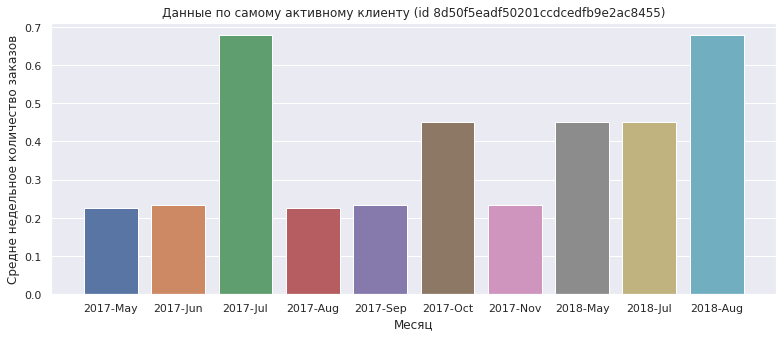

In [68]:
ax = sns.barplot(data = customer_orders_per_month_w[customer_orders_per_month_w['customer_unique_id'] \
                            == customer_orders_per_month_w.customer_unique_id.value_counts().index[0]] \
                                                                                .sort_values('month_dt'),
                 x='year_month', y='orders_per_week')    
ax.set(xlabel='Месяц', ylabel='Средне недельное количество заказов',
       title='Данные по самому активному клиенту (id 8d50f5eadf50201ccdcedfb9e2ac8455)')
ax.plot()

### Задание 5:   
Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. (10 баллов)

In [69]:
orders_users.head(3)

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-08 08:38:49       41ce2a54c0b03bf3443c3d931a367089    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-08 08:38:49      2018-08-08 08:55:23          2018-08-08 13:50:00   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2018-07-24 20:41:37                2018-08-07 15:27:45   
2018-08-08 08:38:49                2018-08-17 18:06:29   

                         order_estimated_delivery_date deep_status  \
order_purchase_timestamp                                             
2017-10-02 10:56:33                         2017-10-18   delivered   
2018-07-24 20:41:37                         2018-08-13   delivered   
2018-08-08 08:38:49                         2018-09-04   delivered   

                                        customer_unique_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       7c396fd4830fd04220f754e42b4e5bff   
2018-07-24 20:41:37       af07308b275d755c9edb36a90c618231   
2018-08-08 08:38:49       3a653a41f6f9fc3d2a113cf8398680e8   

                          customer_zip_code_prefix customer_city  \
order_purchase_timestamp                                           
2017-10-02 10:56:33                           3149     sao paulo   
2018-07-24 20:41:37                          47813     barreiras   
2018-08-08 08:38:49                          75265    vianopolis   

                         customer_state  
order_purchase_timestamp                 
2017-10-02 10:56:33                  SP  
2018-07-24 20:41:37                  BA  
2018-08-08 08:38:49                  GO

In [70]:
orders_users.reset_index(inplace=True)

####  Пишем функцию построения когортного анализа

In [71]:
def cohort_analysis_retention(df, customer_uniq_id, order_timestamp):
    """
    Returns DataFrame with Cohort Analysis Retention by month table. 

    Parameters
    ----------
        df : DataFrame
        customer_uniq_id : Unique customer id
        order_timestamp : DateTime of order purchase        
    """       
    # Выбираем нужные колонки, чтобы не гонять весь массив данных
    df = df[[customer_uniq_id, order_timestamp]]
    
    # Создаем колонку с когортами 'год-месяц' из времени размещения заказа
    df['cohort'] = df[order_timestamp].dt.strftime('%Y-%m')
    
    # Создаем всмомогательный фрейм соотносящий уникальный номер клиента и самую раннюю когорту для него
    start_cohorts = df.groupby(customer_uniq_id, as_index=True).agg({'cohort': 'min'}) \
                      .rename(columns={'cohort': 'start_cohort'})
    
    # Объединяем два фрейма для добавления колонки start_cohort
    df = df.merge(start_cohorts, on='customer_unique_id', how='left')
    
    # Переводим колонки в формат datetime
    df[['cohort', 'start_cohort']] = df[['cohort', 'start_cohort']].apply(pd.to_datetime)
    # Вычисляем в колонку month_diff разницу между текущей когортой для конкретного клиента и первой его
    df['month_diff'] = round((df.cohort - df.start_cohort) / np.timedelta64(1, "M")).astype('int64')
    
    # Переводим к удобному отображения когорт в итоговой таблице
    df['start_cohort'] = df['start_cohort'].dt.strftime('%Y-%m')

    # Фомируем результирующую таблицу, агрегируя по числу уникальных клиентов
    df = df.pivot_table(values='customer_unique_id', index='start_cohort',
                        columns='month_diff', aggfunc=pd.Series.nunique)
    
    return df

In [72]:
res = cohort_analysis_retention(orders_users, 'customer_unique_id', 'order_purchase_timestamp')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
# В таблице можно посмотреть количество уникальных пользователей.
# В колонке 0  отображено число новых клиентов в каждый месяц start_cohort.
# В остальных колонках показано сколько клиентов пришедших изначально в месяце start_cohort,
# совершили покупку в каждом из последующих месяцев
res

month_diff        0     1     2     3     4     5     6     7     8     9   \
start_cohort                                                                 
2016-09          4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2016-10        321.0   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   1.0   
2016-12          1.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-01        764.0   3.0   2.0   1.0   3.0   1.0   4.0   1.0   1.0   NaN   
2017-02       1752.0   4.0   5.0   2.0   7.0   2.0   4.0   3.0   3.0   4.0   
2017-03       2636.0  13.0  10.0  10.0   9.0   4.0   4.0   8.0   9.0   2.0   
2017-04       2352.0  14.0   5.0   4.0   8.0   6.0   8.0   7.0   7.0   4.0   
2017-05       3596.0  18.0  18.0  14.0  11.0  12.0  15.0   6.0   9.0  11.0   
2017-06       3139.0  15.0  11.0  13.0   8.0  12.0  12.0   7.0   4.0   7.0   
2017-07       3894.0  20.0  14.0  10.0  11.0   8.0  12.0   4.0   7.0  10.0   
2017-08       4184.0  29.0  14.0  11.0  15.0  22.0  12.0  11.0   6.0   6.0   
2017-09       4130.0  28.0  22.0  12.0  19.0   9.0   9.0  10.0  12.0   7.0   
2017-10       4470.0  31.0  11.0   4.0  10.0   9.0  10.0  16.0  12.0   9.0   
2017-11       7304.0  40.0  28.0  13.0  14.0  13.0   8.0  14.0  10.0   4.0   
2017-12       5487.0  14.0  15.0  19.0  15.0  11.0   9.0   3.0  12.0   NaN   
2018-01       7025.0  24.0  27.0  20.0  20.0  11.0  12.0  16.0   NaN   NaN   
2018-02       6451.0  25.0  25.0  19.0  17.0  14.0  13.0   NaN   NaN   NaN   
2018-03       6965.0  32.0  22.0  20.0   9.0   9.0   NaN   NaN   NaN   NaN   
2018-04       6711.0  39.0  21.0  16.0   9.0   NaN   NaN   NaN   NaN   NaN   
2018-05       6622.0  35.0  18.0  14.0   NaN   NaN   NaN   NaN   NaN   NaN   
2018-06       5940.0  25.0  17.0   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
2018-07       6071.0  44.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-08       6271.0   7.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-09          5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-10          1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

month_diff      10    11   12    13   14   15   16   17   19   20  
start_cohort                                                       
2016-09        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2016-10        NaN   1.0  NaN   1.0  NaN  1.0  NaN  1.0  2.0  2.0  
2016-12        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-01        3.0   1.0  6.0   3.0  1.0  1.0  2.0  3.0  1.0  NaN  
2017-02        2.0   5.0  3.0   3.0  2.0  1.0  1.0  4.0  NaN  NaN  
2017-03       10.0   4.0  6.0   3.0  4.0  6.0  2.0  4.0  NaN  NaN  
2017-04        6.0   2.0  2.0   1.0  2.0  2.0  5.0  NaN  NaN  NaN  
2017-05        9.0  12.0  9.0   1.0  7.0  9.0  NaN  NaN  NaN  NaN  
2017-06       10.0  11.0  5.0   4.0  6.0  NaN  NaN  NaN  NaN  NaN  
2017-07        9.0  12.0  5.0  10.0  NaN  NaN  NaN  NaN  NaN  NaN  
2017-08       10.0   8.0  4.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-09       11.0   3.0  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-10        9.0   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-11        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-12        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-01        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-02        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-03        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-04        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-05        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-06        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-07        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-08        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-09        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-10        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN

#### Переводим таблицу из абсолютных чисел в относительные % от стартового количества новых в каждой когорте

In [74]:
# Переводим таблицу из абсолютных чисел в относительные % от стартового количества новых в каждой когорте
def retention_rate(df_cohort_analysis):
    """
    Converts Cohort Analysis Counts Retention table into Cohort Analysis Retention Rate table.
    """
    return df_cohort_analysis.div(df_cohort_analysis[0], axis=0).mul(100)

In [75]:
rr = retention_rate(res)
rr

month_diff       0           1         2         3         4         5   \
start_cohort                                                              
2016-09       100.0         NaN       NaN       NaN       NaN       NaN   
2016-10       100.0         NaN       NaN       NaN       NaN       NaN   
2016-12       100.0  100.000000       NaN       NaN       NaN       NaN   
2017-01       100.0    0.392670  0.261780  0.130890  0.392670  0.130890   
2017-02       100.0    0.228311  0.285388  0.114155  0.399543  0.114155   
2017-03       100.0    0.493171  0.379363  0.379363  0.341426  0.151745   
2017-04       100.0    0.595238  0.212585  0.170068  0.340136  0.255102   
2017-05       100.0    0.500556  0.500556  0.389321  0.305895  0.333704   
2017-06       100.0    0.477859  0.350430  0.414145  0.254858  0.382287   
2017-07       100.0    0.513611  0.359527  0.256805  0.282486  0.205444   
2017-08       100.0    0.693117  0.334608  0.262906  0.358509  0.525813   
2017-09       100.0    0.677966  0.532688  0.290557  0.460048  0.217918   
2017-10       100.0    0.693512  0.246085  0.089485  0.223714  0.201342   
2017-11       100.0    0.547645  0.383352  0.177985  0.191676  0.177985   
2017-12       100.0    0.255149  0.273373  0.346273  0.273373  0.200474   
2018-01       100.0    0.341637  0.384342  0.284698  0.284698  0.156584   
2018-02       100.0    0.387537  0.387537  0.294528  0.263525  0.217021   
2018-03       100.0    0.459440  0.315865  0.287150  0.129218  0.129218   
2018-04       100.0    0.581135  0.312919  0.238415  0.134108       NaN   
2018-05       100.0    0.528541  0.271821  0.211416       NaN       NaN   
2018-06       100.0    0.420875  0.286195       NaN  0.016835       NaN   
2018-07       100.0    0.724757  0.032944       NaN       NaN       NaN   
2018-08       100.0    0.111625  0.031893       NaN       NaN       NaN   
2018-09       100.0         NaN       NaN       NaN       NaN       NaN   
2018-10       100.0         NaN       NaN       NaN       NaN       NaN   

month_diff          6         7         8         9         10        11  \
start_cohort                                                               
2016-09            NaN       NaN       NaN       NaN       NaN       NaN   
2016-10       0.311526       NaN       NaN  0.311526       NaN  0.311526   
2016-12            NaN       NaN       NaN       NaN       NaN       NaN   
2017-01       0.523560  0.130890  0.130890       NaN  0.392670  0.130890   
2017-02       0.228311  0.171233  0.171233  0.228311  0.114155  0.285388   
2017-03       0.151745  0.303490  0.341426  0.075873  0.379363  0.151745   
2017-04       0.340136  0.297619  0.297619  0.170068  0.255102  0.085034   
2017-05       0.417130  0.166852  0.250278  0.305895  0.250278  0.333704   
2017-06       0.382287  0.223001  0.127429  0.223001  0.318573  0.350430   
2017-07       0.308166  0.102722  0.179764  0.256805  0.231125  0.308166   
2017-08       0.286807  0.262906  0.143403  0.143403  0.239006  0.191205   
2017-09       0.217918  0.242131  0.290557  0.169492  0.266344  0.072639   
2017-10       0.223714  0.357942  0.268456  0.201342  0.201342       NaN   
2017-11       0.109529  0.191676  0.136911  0.054765       NaN       NaN   
2017-12       0.164024  0.054675  0.218699       NaN       NaN       NaN   
2018-01       0.170819  0.227758       NaN       NaN       NaN       NaN   
2018-02       0.201519       NaN       NaN       NaN       NaN       NaN   
2018-03            NaN       NaN       NaN       NaN       NaN       NaN   
2018-04            NaN       NaN       NaN       NaN       NaN       NaN   
2018-05            NaN       NaN       NaN       NaN       NaN       NaN   
2018-06            NaN       NaN       NaN       NaN       NaN       NaN   
2018-07            NaN       NaN       NaN       NaN       NaN       NaN   
2018-08            NaN       NaN       NaN       NaN       NaN       NaN   
2018-09            NaN       NaN       NaN       NaN       NaN       NaN  

#### Строим треугольный Heatmap по таблице когортного анализа

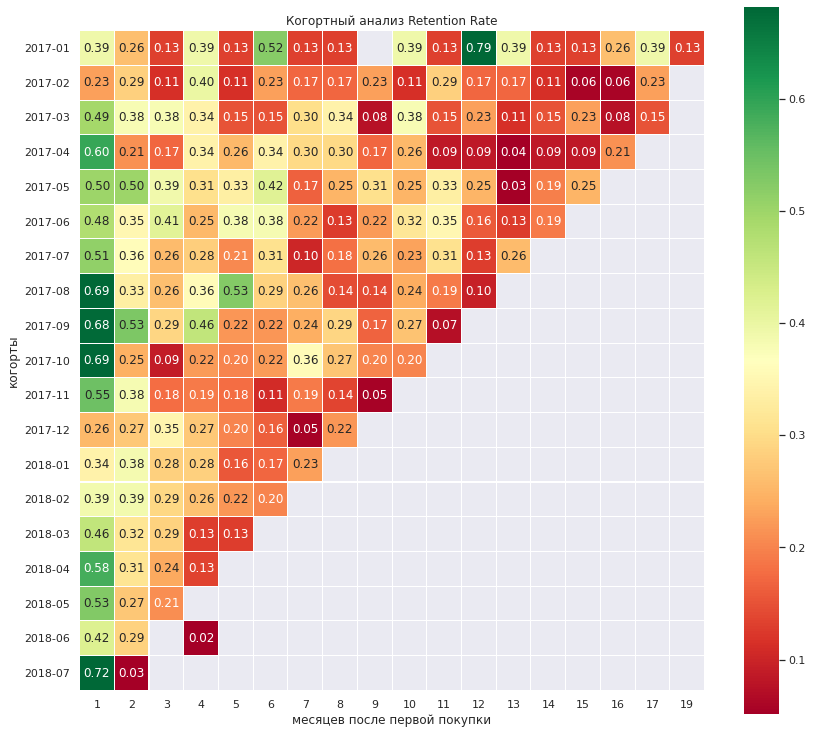

In [76]:
plt.figure(figsize=(14, 13))
ax = sns.heatmap(rr.drop(columns=[0, 20], index=['2016-09', '2016-10', '2016-12',
                                           '2018-08', '2018-09', '2018-10']),
                 annot=True, fmt='.2f', cmap='RdYlGn', linewidths=.05, square=True, robust=True)
plt.title('Когортный анализ Retention Rate')
plt.ylabel('когорты')
plt.xlabel('месяцев после первой покупки')
plt.show()

### Выводы
Из графика видно, что в последующие месяцы после первой покупки, повторно клиенты почти не покупают.
Видны небольшие сезонные повышения Retension в первый месяц (апрель, август-октябрь).
Если рассматривать 3-й месяц, то повышения видны в 2017-03, 2017-06 и 2017-12 когортах

#### В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц

In [77]:
period = ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
          '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
rr[rr.index.isin(period)][3].idxmax()

'2017-06'

### Ответ: 
когорта '2017-06'. Также ее можно найти по графику выше

### Задание 6:   
Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. (35 баллов)

- написание функции, генерирующей таблицу (customer_id, recency, frequency, monetary, r, f, m, rfm) из фрейма с колонками (customer_id, order_timestamp, price)


- вывод графика по всем кластерам rfm
- вывод графика в группировке кластеров 

Подготавливаем данные

In [78]:
orders_users.nunique()

order_purchase_timestamp         98875
order_id                         99441
customer_id                      99441
order_status                         8
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
deep_status                         11
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
dtype: int64

In [79]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [80]:
items.price.sum()

13591643.700000003

In [81]:
# фрейм orders_active с заказами, у которых статус не 'created', не 'unavailable' и не 'canceled'
orders_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
dtype: int64

In [82]:
# фрейм из таблицы users, c клиентами у которых customer_id пересекается с customer_id 
# в таблице orders_active. Фактически в users_active лежит фрейм со всеми клиентами, которые
# совершили хотя бы одну оплату заказа
users_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
customer_unique_id               94986
customer_zip_code_prefix         14964
customer_city                     4109
customer_state                      27
dtype: int64

In [83]:
# вычисляем для каждого заказа total
orders_amount = items.groupby('order_id', as_index=False).agg({'price': 'sum'})\
                     .rename(columns={'price': 'order_total'})
orders_amount.order_id.nunique()

98666

In [84]:
# Сливаем вместе все три таблицы, из orders нам нужен order_purchase_timestamp,
# из users - customer_unique_id, из items - amount(сумма каждого закза)

In [85]:
# делаем inner, так как в order_total есть 3 NaN
orders_users_total = users_active.merge(orders_amount, how='inner', on='order_id')

In [86]:
orders_users_total.nunique()

order_id                         98199
customer_id                      98199
order_status                         5
order_purchase_timestamp         97647
order_approved_at                89757
order_delivered_carrier_date     80950
order_delivered_customer_date    95658
order_estimated_delivery_date      447
customer_unique_id               94983
customer_zip_code_prefix         14964
customer_city                     4109
customer_state                      27
order_total                       7715
dtype: int64

In [87]:
orders_users_total.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date      617
order_delivered_customer_date    1729
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_total                         0
dtype: int64

In [88]:
orders_users_total_4cols = orders_users_total[['customer_unique_id', 'order_id', 'order_purchase_timestamp',  'order_total']]
orders_users_total_4cols

customer_unique_id                          order_id  \
0      7c396fd4830fd04220f754e42b4e5bff  e481f51cbdc54678b7cc49136f2d6af7   
1      af07308b275d755c9edb36a90c618231  53cdb2fc8bc7dce0b6741e2150273451   
2      3a653a41f6f9fc3d2a113cf8398680e8  47770eb9100c2d0c44946d9cf07ec65d   
3      7c142cf63193a1473d2e66489a9ae977  949d5b44dbf5de918fe9c16f97b45f8a   
4      72632f0f9dd73dfee390c9b22eb56dd6  ad21c59c0840e6cb83a9ceb5573f8159   
...                                 ...                               ...   
98194  6359f309b166b0196dbf7ad2ac62bb5a  9c5dedf39a927c1b2549525ed64a053c   
98195  da62f9e57a76d978d02ab5362c509660  63943bddc261676b46f01ca7ac2f7bd8   
98196  737520a9aad80b3fbbdad19b66b37b30  83c1379a015df1e13d02aae0204711ab   
98197  5097a5312c8b157bb7be58ae360ef43c  11c177c8e97725db2631073c19f07b62   
98198  60350aa974b26ff12caad89e55993bd6  66dea50a8b16d9b4dee7af250b4be1a5   

      order_purchase_timestamp  order_total  
0          2017-10-02 10:56:33        29.99  
1          2018-07-24 20:41:37       118.70  
2          2018-08-08 08:38:49       159.90  
3          2017-11-18 19:28:06        45.00  
4          2018-02-13 21:18:39        19.90  
...                        ...          ...  
98194      2017-03-09 09:54:05        72.00  
98195      2018-02-06 12:58:58       174.90  
98196      2017-08-27 14:46:43       205.99  
98197      2018-01-08 21:28:27       359.98  
98198      2018-03-08 20:57:30        68.50  

[98199 rows x 4 columns]

#### Пишем функцию для деления значений колонки на категории в количестве number_clusters

In [89]:
# Делит колонку на кластеры по квантилям, количество кластеров задается в number_clusters
def to_clusters(column, number_clusters=3, quantiles=[]):
    if quantiles == []: 
        quantiles = np.linspace(0, 1, num = number_clusters, endpoint=False).tolist()
    else:
        quantiles.insert(0, 0)
    quantiles.append(1.0)
        
    masks = []
    for i in range(number_clusters-1):
        mask = (column >= column.quantile(quantiles[i])) & (column < column.quantile(quantiles[i+1]))         
        masks.append(mask)
    masks.append(column >= column.quantile(quantiles[number_clusters-1]))

    for i in range(len(masks)):
        column.mask(masks[i], i+1, inplace=True)

    return column

#### Пишем функцию, генерирующую таблицу (customer_id, recency, frequency, monetary, r, f, m, rfm) из фрейма с колонками (customer_id, order_id, order_timestamp, order_total)

In [90]:
def rfm_table(df, customer_unique_id, order_id, order_purchase_timestamp,
              order_total, rfm_clusters_quantity={'r':3, 'f':3, 'm':3},
              quantiles={'r':[], 'f':[], 'm':[]}):
    
    # отбираем неодходимые колонки для анализа rfm
    df = df[[customer_unique_id, order_id, order_purchase_timestamp, order_total]]
        
    # добавляем поля recency и frequency
    # max 'order_purchase_timestamp' - заказ с самым свежим timestamp
    # count 'order_purchase_timestamp' - количество заказов клиента за всё время
    customer_rf = df.groupby(customer_unique_id)[order_purchase_timestamp] \
                    .agg(['max', 'count']).reset_index() \
                    .rename(columns={'max': 'recency', 'count': 'frequency'})
    
    # добавляем поле monetary
    # sum 'order_total' - денег потрачено клиентом за всё время
    customer_m = df.groupby(customer_unique_id)[order_total] \
                    .agg('sum').reset_index() \
                    .rename(columns={order_total: 'monetary'})
    
    # сводим в одну таблицу
    customer_rfm = customer_rf.merge(customer_m, how='outer', on=customer_unique_id)
    
    customer_rfm.recency = customer_rfm.recency.astype('datetime64')
        
    # создаем новые колонки для дальнейшего деления на кластеры
    customer_rfm['r'] = customer_rfm['recency']
    customer_rfm['f'] = customer_rfm['frequency']
    customer_rfm['m'] = customer_rfm['monetary']

    # применяем функцию к колонкам R, F, M
    customer_rfm['r'] = to_clusters(customer_rfm['r'], rfm_clusters_quantity['r'], quantiles['r'])
    customer_rfm['f'] = to_clusters(customer_rfm['f'], rfm_clusters_quantity['f'], quantiles['f'])
    customer_rfm['m'] = to_clusters(customer_rfm['m'], rfm_clusters_quantity['m'], quantiles['m'])

    # переводим к целым значениям
    customer_rfm[['r', 'f', 'm']] = customer_rfm[['r', 'f', 'm']].astype('int64')  

    # создаем rfm кластеры
    customer_rfm['rfm'] = customer_rfm['r']*100 + customer_rfm['f']*10 + customer_rfm['m']
    
    return customer_rfm

In [91]:
rfm = rfm_table(df = orders_users_total_4cols, 
          customer_unique_id = 'customer_unique_id',
          order_id = 'order_id',
          order_purchase_timestamp = 'order_purchase_timestamp', 
          order_total = 'order_total')
rfm

customer_unique_id             recency  frequency  \
0      0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27          1   
2      0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03          1   
3      0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41          1   
4      0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42          1   
...                                 ...                 ...        ...   
94978  fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:00:36          1   
94979  fffea47cd6d3cc0a88bd621562a9d061 2017-12-10 20:07:56          1   
94980  ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16          1   
94981  ffff5962728ec6157033ef9805bacc48 2018-05-02 15:17:41          1   
94982  ffffd2657e2aad2907e67c3e9daecbeb 2017-05-02 20:18:45          1   

       monetary  r  f  m  rfm  
0        129.90  3  3  3  333  
1         18.90  3  3  1  331  
2         69.00  1  3  2  132  
3         25.99  1  3  1  131  
4        180.00  2  3  3  233  
...         ... .. .. ..  ...  
94978   1570.00  1  3  3  133  
94979     64.89  2  3  2  232  
94980     89.90  1  3  2  132  
94981    115.00  3  3  2  332  
94982     56.99  1  3  1  131  

[94983 rows x 8 columns]

In [92]:
rfm.rfm.value_counts()

132    10823
231    10752
333    10652
332    10639
233    10634
131    10463
133    10375
331    10370
232    10275
Name: rfm, dtype: int64

Видим, что кластеров rfm явно не 27, значит наши данные сдвинуты, некоторые кластеры оказались пусты, так как по-умолчанию rfm_table() делит на кластеры с равными диапазонами квантилей. Frequency оказалась очень сильно сдвинута, потому что практически все клиенты покупают только один раз. Поэтому F во всех кластерах имеет только одно значение.

In [93]:
# найдем квантили, чтобы разделить клиентов по всем кластерам внутри Frequency
rfm.frequency.rank().value_counts(normalize=True)

46048.5    0.969605
93422.0    0.027910
94841.5    0.001979
94950.0    0.000305
94969.0    0.000095
94976.0    0.000053
94980.0    0.000032
94983.0    0.000011
94982.0    0.000011
Name: frequency, dtype: float64

In [94]:
rfm.frequency.quantile(.97)

2.0

Во втором F будет те, кто оформил 2 заказа

In [95]:
rfm.frequency.quantile(.998)

3.0

В третьем F будет те, кто оформил 3 заказа и более

In [96]:
rfm = rfm_table(df = orders_users_total, 
          customer_unique_id = 'customer_unique_id',
          order_id = 'order_id',
          order_purchase_timestamp = 'order_purchase_timestamp', 
          order_total = 'order_total',
          rfm_clusters_quantity={'r':3, 'f':3, 'm':3},
          quantiles={'r':[], 'f':[.97, .998], 'm':[]})
rfm.head(3)

customer_unique_id             recency  frequency  monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27          1     129.9   
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27          1      18.9   
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03          1      69.0   

   r  f  m  rfm  
0  3  1  3  313  
1  3  1  1  311  
2  1  1  2  112

In [97]:
rfm.f.value_counts()

1    92096
2     2651
3      236
Name: f, dtype: int64

### Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M)

Создаем словарь с описанием RFM кластеров

In [98]:
description = { '111':'Потерянные экономные',
                '112':'Одноразовые',
                '113':'Одноразовые',
                '121':'Уходящие редкие',
                '122':'Уходящие редкие',
                '123':'Уходящие редкие',
                '131':'Уходящие постоянные',
                '132':'Уходящие хорошие постоянные',
                '133':'Уходящие VIP',               
                '211':'Спящие разовые с маленьким чеком',
                '212':'Спящие разовые с маленьким чеком',
                '213':'Спящие разовые с маленьким чеком',
                '221':'Спящие редкие с маленьким чеком',
                '222':'Спящие редкие со средним чеком',
                '223':'Спящие редкие с высоким чеком',
                '231':'Спящие постоянные с маленьким чеком',
                '232':'Спящие постоянные со средним чеком',
                '233':'Спящие постоянные с высоким чеком',               
                '311':'Новички с маленьким чеком',
                '312':'Новички со средним чеком',
                '313':'Новички с высоким чеком',
                '321':'Постоянные с маленьким чеком',
                '322':'Постоянные со средним чеком',
                '323':'Постоянные с высоким чеком',
                '331':'Постоянные с маленьким чеком',
                '332':'Постоянные со средним чеком',
                '333':'VIP'
            }

In [99]:
df_desc = pd.Series(description)
df_desc = df_desc.to_frame().reset_index() \
            .rename(columns={'index': 'rfm', 0: 'description'}).astype({'rfm': 'int64'})
df_desc.head(1)

rfm           description
0  111  Потерянные экономные

In [100]:
# Считаем количество клиентов в каждом кластере
rfm_grouped = rfm.groupby('rfm').customer_unique_id.agg('count').to_frame().reset_index()\
                    .rename(columns={'customer_unique_id': 'customers'})
rfm_grouped.head(1)

rfm  customers
0  111      10388

In [101]:
# Добавляем колонку с описанием
rfm_grouped_desc = rfm_grouped.merge(df_desc, how='outer', on='rfm')
rfm_grouped_desc.customers.fillna(0, inplace=True)
rfm_grouped_desc.head(1)

rfm  customers           description
0  111    10388.0  Потерянные экономные

In [102]:
# Добавляем колонку для подписей на графике
rfm_grouped_desc = rfm_grouped_desc.astype({'rfm': 'string', 'description': 'string'})
rfm_grouped_desc['desc_rfm'] = rfm_grouped_desc.description + ' : ' + rfm_grouped_desc.rfm

In [103]:
# Добавляем колонку c количествой клиентов в каждом кластере в долях
rfm_grouped_desc.insert(2, column='customers_fraction',
                        value=rfm_grouped_desc.customers / rfm_grouped_desc.customers.sum())
rfm_grouped_desc.head(1)

rfm  customers  customers_fraction           description  \
0  111    10388.0            0.109367  Потерянные экономные   

                     desc_rfm  
0  Потерянные экономные : 111

#### Выводим Bar Chart распределения клиентов по RFM-кластерам

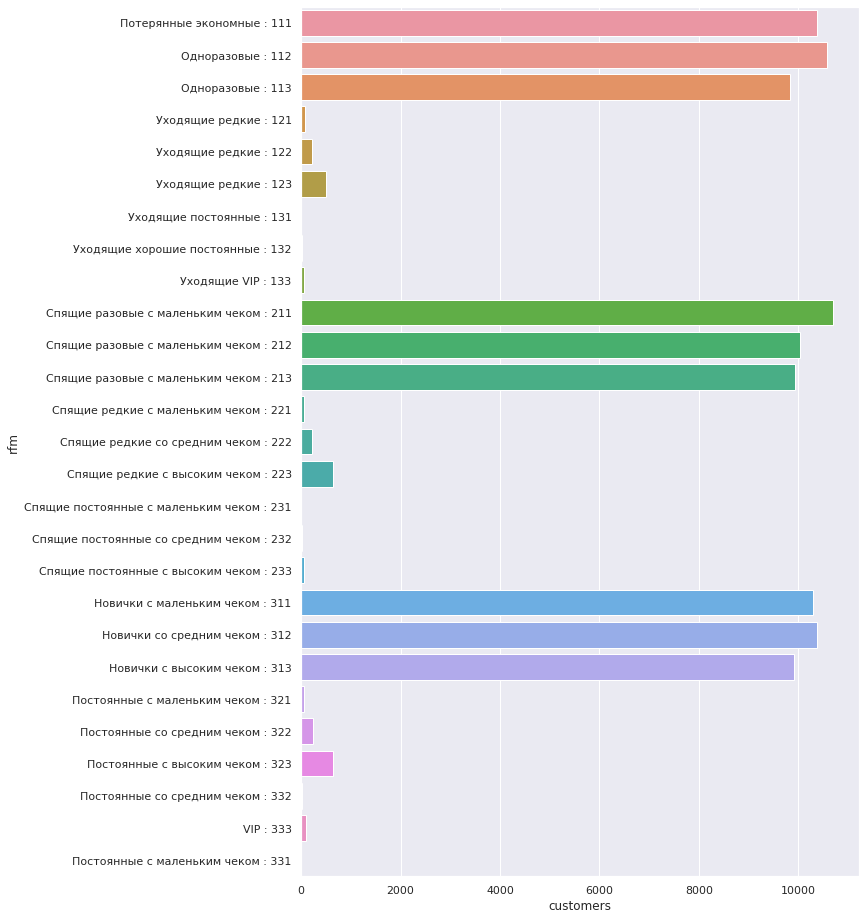

In [104]:
plt.figure(figsize=(10, 16))
sns.barplot(data=rfm_grouped_desc, y='rfm', x='customers', orient='h')
plt.yticks(ticks=np.arange(27), labels=rfm_grouped_desc.desc_rfm)
plt.show()

In [105]:
# заменияем 0 близкими значениями, для построения распределения долей пользователей по кластерам RFM
rfm_grouped_desc.customers.replace(to_replace=0, value=0.00001, inplace=True)

#### Выводим 'Square Pie' распределения клиентов по RFM-кластерам

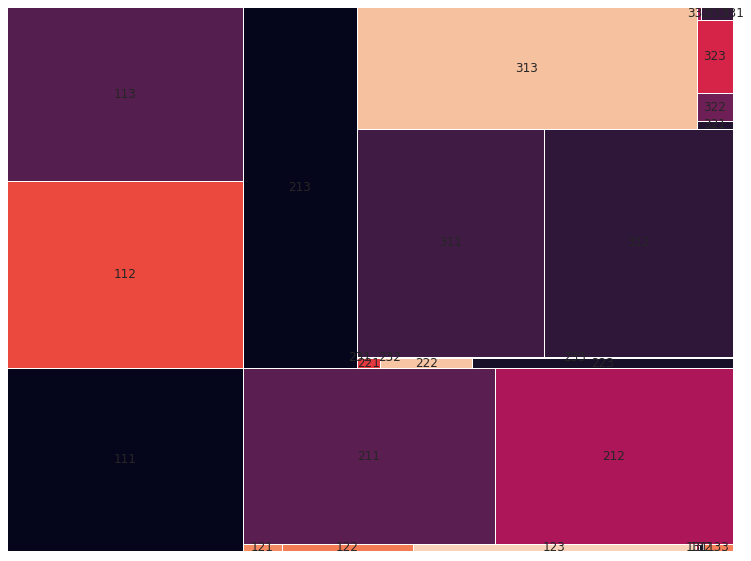

In [106]:
plt.figure(figsize=(13, 10))
squarify.plot(sizes = rfm_grouped_desc.customers, label = rfm_grouped_desc.rfm)
plt.axis('off')
plt.show()

### Ответ 
Выводим средние значения метрик R, F, M для каждого кластера 

In [107]:
df = rfm.groupby('rfm')['frequency', 'monetary'].mean()
df['recency'] = rfm.groupby('rfm')['recency'].agg(pd.Series.mean)
df

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



frequency    monetary                       recency
rfm                                                     
111   1.000000   34.538202 2017-07-04 18:47:01.820658432
112   1.000000   87.396543 2017-07-08 02:47:32.481443072
113   1.000000  311.523983 2017-07-06 10:43:34.537984512
121   2.000000   43.041739 2017-06-25 05:58:28.623187968
122   2.000000   96.193304 2017-07-22 07:12:20.911894272
123   2.000000  339.342179 2017-07-22 13:21:56.706721024
131   3.666667   40.531667 2017-02-02 13:17:12.500000000
132   3.142857   96.764286 2017-07-19 02:58:29.999999744
133   3.078431  418.281569 2017-08-08 07:48:11.470587904
211   1.000000   34.955835 2018-01-21 20:00:00.612924416
212   1.000000   89.657835 2018-01-20 06:03:48.759661568
213   1.000000  282.097511 2018-01-21 11:34:05.369956864
221   2.000000   43.475345 2018-01-22 23:53:51.275862016
222   2.000000   96.752566 2018-01-17 21:53:55.535398400
223   2.000000  312.456131 2018-01-24 06:52:26.297972224
231   3.000000   48.800000 2018-01-04 05:39:58.000000000
232   3.000000  105.683333 2018-03-05 11:08:59.333333248
233   3.481481  448.792778 2018-02-01 18:58:20.296296192
311   1.000000   34.926437 2018-06-16 03:25:12.245779200
312   1.000000   90.460031 2018-06-14 17:55:08.389215232
313   1.000000  304.282810 2018-06-13 09:32:07.049077760
321   2.000000   43.616406 2018-06-15 14:01:04.093750016
322   2.000000   95.060166 2018-06-13 22:19:17.153527040
323   2.000000  329.918297 2018-06-16 10:50:11.528391424
332   3.000000  100.765385 2018-06-25 23:10:54.769230848
333   3.610526  533.756526 2018-06-13 04:56:05.431579136

In [108]:
rfm_grouped_desc.head(1)

rfm  customers  customers_fraction           description  \
0  111    10388.0            0.109367  Потерянные экономные   

                     desc_rfm  
0  Потерянные экономные : 111

In [109]:
# Добавляем отдельные колонки R, F, M
rfm_grouped_desc['r'] = rfm_grouped_desc.rfm.astype('int').floordiv(100)
rfm_grouped_desc['f'] = rfm_grouped_desc.rfm.astype('int').floordiv(10).mod(10)
rfm_grouped_desc['m'] = rfm_grouped_desc.rfm.astype('int').mod(10)
rfm_grouped_desc.head(3)

rfm  customers  customers_fraction           description  \
0  111    10388.0            0.109367  Потерянные экономные   
1  112    10589.0            0.111483           Одноразовые   
2  113     9833.0            0.103524           Одноразовые   

                     desc_rfm  r  f  m  
0  Потерянные экономные : 111  1  1  1  
1           Одноразовые : 112  1  1  2  
2           Одноразовые : 113  1  1  3

### RF-анализ 

In [110]:
# RF-анализ доли клиентов в %
# Анализ по давности покупок и частоте покупок
# Показывает как часто клиенты совершают покупки.
# Позволяет выявить клиентов:
#   кто покупал недавно и покупает часто (RF сегмент 33)
#   кто покупал давно, но часто (RF сегмент 13)
rf_clients = rfm_grouped_desc.pivot_table(values='customers_fraction',
                             index='f',
                             columns='r',
                             aggfunc='sum').mul(100)

In [111]:
# RF-анализ вклада в итоговую сумму каждого сегмента в %
rf_income = rfm.pivot_table(values='monetary',
                index='f',
                columns='r',
                aggfunc='sum').div(rfm.monetary.sum()).mul(100)

In [112]:
# RF-анализ средних трат клиента для каждого сегмента
rf_income_per_client = rfm.pivot_table(values='monetary',
                index='f',
                columns='r',
                aggfunc='mean')

### RM-анализ

In [113]:
# RM-анализ доли клиентов в %
# Анализ показывает распределение по параметрам Recency и Monetary
# Позволяет выявить тех, кто приносит больше всего прибыли и чей вклад незначителен
#  кто покупал недавно и по-крупному (RM сегмент 33),
#  кто покупал давно и по-крупному (RM сегмент 13)
rm_clients = rfm_grouped_desc.pivot_table(values='customers_fraction',
                             index='m',
                             columns='r',
                             aggfunc='sum').mul(100)

In [114]:
# RM-анализ вклада в итоговую сумму каждого сегмента в %
rm_income = rfm.pivot_table(values='monetary',
                index='m',
                columns='r',
                aggfunc='sum').div(rfm.monetary.sum()).mul(100)

In [115]:
# RM-анализ средних трат клиента для каждого сегмента
rm_income_per_client = rfm.pivot_table(values='monetary',
                index='m',
                columns='r',
                aggfunc='mean')

### FM-анализ

In [116]:
# FM-анализ доли клиентов в %
# Анализ показывает распределение в зависимости от частоты и суммы покупок
# Позволяет выявить клиентов:
#  кто покупает редко, но на большие суммы (FM сегмент 13)
#  кто покупает часто, но маленькими чеками (FM сегмент 31)
fm_clients = rfm_grouped_desc.pivot_table(values='customers_fraction',
                             index='m',
                             columns='f',
                             aggfunc='sum').mul(100)

In [117]:
# FM-анализ вклада в итоговую сумму каждого сегмента в %
fm_income = rfm.pivot_table(values='monetary',
                index='m',
                columns='f',
                aggfunc='sum').div(rfm.monetary.sum()).mul(100)

In [118]:
# FM-анализ средних трат клиента для каждого сегмента
fm_income_per_client = rfm.pivot_table(values='monetary',
                index='m',
                columns='f',
                aggfunc='mean')

### Итоговый график

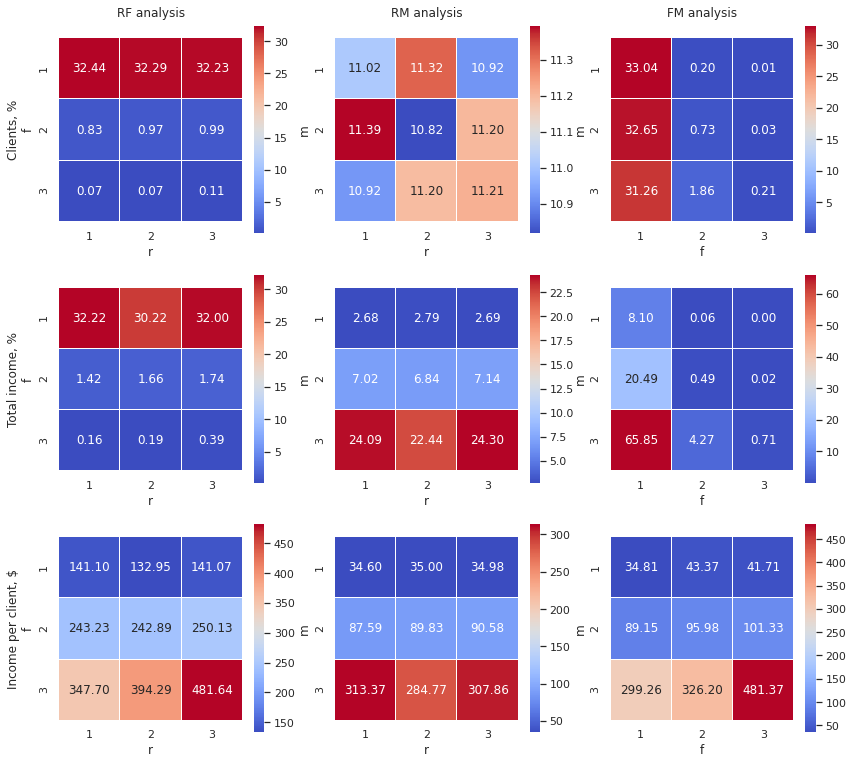

In [119]:
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(14, 13)
cm = 'coolwarm'
lw = .05
s = True

axes[0, 0].set_title('RF analysis\n')
sns.heatmap(rf_clients, annot=True, fmt='.02f', cmap=cm, linewidths=lw, square=s, ax=axes[0, 0])
sns.heatmap(rf_income, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[1, 0])
sns.heatmap(rf_income_per_client, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[2, 0])

axes[0, 1].set_title('RM analysis\n')
sns.heatmap(rm_clients, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[0, 1])
sns.heatmap(rm_income, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[1, 1])
sns.heatmap(rm_income_per_client, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[2, 1])

axes[0, 2].set_title('FM analysis\n')
sns.heatmap(fm_clients, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[0, 2])
sns.heatmap(fm_income, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[1, 2])
sns.heatmap(fm_income_per_client, annot=True, fmt='.2f', cmap=cm, linewidths=lw, square=s, ax=axes[2, 2])

axes[0, 0].set_ylabel('Clients, %\nf')
axes[1, 0].set_ylabel('Total income, %\nf')
axes[2, 0].set_ylabel('Income per client, $\nf')

plt.show()

### Выводы  
На итоговом графике по RFM-анализу видно, что наши клиенты покупают очень редко (из данных можно увидет, что абсолютное большинство размещают заказ только один раз), при этом по Recency видно равномерное разделение клиентов, это означает, что в рамках изученного периода новые клиенты приходили регулярно. Из вышенаписанного можно сделать вывод о том, что с привлечение новых клиентов у нас всё в порядке, но очень плохо с удержанием. Клиенты практически не приходят повторно.  
####  
Еще из графика RF-Income_per_client видно, что постепенно клиенты оставляют всё больше денег, то есть, платежеспособность растёт, (скорее всего это из-за того, что в кластерах с F=3: '_3_' оказалось очень мало клиентов, ведь мы разделили по кватилям [0.97, 0.998]). 
####   
Также это заметно на графике RM-Clients, на котором во всех кластерах среза RF количество клиентов почти одинаково. То есть тех кто покупал недавно и много столько же, сколько и тех, кто покупал давно и немного.